For this exercise, I am working with a fairly large dataset about retail purchases, to try to understand consumer behaviour.

In [77]:
import pandas as pd

df = pd.read_csv('retail_data.csv')
df.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,...,324.086270,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts
1,2174773.0,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,...,806.707815,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.0,Lenovo Tab
2,6679610.0,30192.0,Scott Jensen,Shane85@gmail.com,8.362160e+09,4133 Young Canyon,Geelong,New South Wales,75929.0,Australia,...,1063.432799,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.0,Sports equipment
3,7232460.0,62101.0,Joseph Miller,Mary34@gmail.com,2.776752e+09,8148 Thomas Creek Suite 100,Edmonton,Ontario,88420.0,Canada,...,2466.854021,Home Decor,Home Depot,Tools,Excellent,Standard,PayPal,Processing,4.0,Utility knife
4,4983775.0,27901.0,Debra Coleman,Charles30@gmail.com,9.098268e+09,5813 Lori Ports Suite 269,Bristol,England,48704.0,UK,...,248.553049,Grocery,Nestle,Chocolate,Bad,Standard,Cash,Shipped,1.0,Chocolate cookies


There is a lot of categorical data in this dataset, so a lot of columns need to be encoded.

In [78]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['Name', 'Email', 'Phone', 'Address', 'City', 'State', 'Country', 'Gender', 'Income', 
                     'Customer_Segment', 'Month', 'Product_Category', 'Product_Brand', 'Product_Type', 
                     'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status', 'products']

le = LabelEncoder()

for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])

df.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,109110,16503,13801,118307,35,4,77985.0,2,...,324.086270,1,10,23,2,1,2,3,5.0,86
1,2174773.0,69749.0,86175,35163,194622,245491,87,9,99071.0,3,...,806.707815,2,14,28,2,2,1,2,4.0,164
2,6679610.0,30192.0,135685,44930,245087,123528,46,33,75929.0,0,...,1063.432799,0,11,3,0,1,1,2,2.0,268
3,7232460.0,62101.0,77466,35499,58892,243686,40,39,88420.0,1,...,2466.854021,4,6,31,2,2,3,2,4.0,301
4,4983775.0,27901.0,41207,9581,269425,173832,20,9,48704.0,3,...,248.553049,3,9,4,1,2,0,3,1.0,58


The dates are also very inconsistently formatted, so the following code aims to homogenize the dates into a single format.

In [79]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)
df = df.dropna(subset=['Date'])

df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'].head(10)

C:\Users\Jan\AppData\Local\Temp\ipykernel_13524\505535603.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)


0     2023-09-18
1     2023-12-31
2     2023-04-26
5     2023-09-21
6     2023-06-26
7     2023-03-24
10    2023-07-20
11    2023-06-21
14    2023-11-18
15    2023-06-15
Name: Date, dtype: object

Here we cluster the data in an RFM analysis, in an attempt to better understand the different types of customers the business has.

In [80]:
from sklearn.cluster import KMeans
import numpy as np

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

kmeans_rfm_df = df.groupby('Customer_ID').agg({
    'Date': lambda x: (df['Date'].max() - x.max()).days,
    'Customer_ID': 'count',
    'Total_Amount': 'sum'
}).rename(columns={'Date': 'Recency', 'Customer_ID': 'Frequency', 'Total_Amount': 'Monetary'})

kmeans_rfm_df['Recency'] = kmeans_rfm_df['Recency'] / kmeans_rfm_df['Recency'].max()
kmeans_rfm_df['Frequency'] = kmeans_rfm_df['Frequency'] / kmeans_rfm_df['Frequency'].max()
kmeans_rfm_df['Monetary'] = kmeans_rfm_df['Monetary'] / kmeans_rfm_df['Monetary'].max()

kmeans = KMeans(n_clusters=4)
kmeans_rfm_df['Cluster'] = kmeans.fit_predict(kmeans_rfm_df[['Recency', 'Frequency', 'Monetary']])

kmeans_rfm_df.head()

,Recency,Frequency,Monetary,Cluster
Customer_ID,,,,
10000.0,0.288952,0.4,0.228323,2
10001.0,0.294618,0.4,0.194097,2
10002.0,0.266289,0.4,0.170853,2
10003.0,0.643059,0.1,0.086209,0
10004.0,0.084986,0.1,0.070268,3


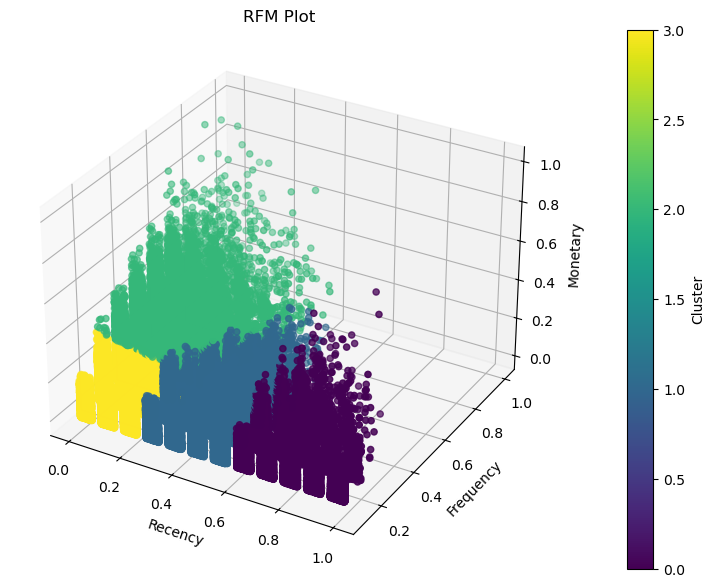

In [81]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(kmeans_rfm_df['Recency'], kmeans_rfm_df['Frequency'], kmeans_rfm_df['Monetary'], c=kmeans_rfm_df['Cluster'])

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Plot')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster')

plt.show()

There seems to be mostly a split into recency. There is quite some value to be found in both the very recent customers who seem to have decent monetary totals, and the cluster with high frequency and monetary totals, who may need to be dragged back into the business in some way, due to the tendency towards low recency.

The following code merges the previously assigned clusters to the original dataset, to do some further analysis on the demographics of the different clusters.

In [82]:
kmeans_cluster_df = df.merge(kmeans_rfm_df[['Cluster']], left_on='Customer_ID', right_index=True, how='left')
kmeans_cluster_df.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products,Cluster
0,8691788.0,37249.0,109110,16503,13801,118307,35,4,77985.0,2,...,1,10,23,2,1,2,3,5.0,86,1.0
1,2174773.0,69749.0,86175,35163,194622,245491,87,9,99071.0,3,...,2,14,28,2,2,1,2,4.0,164,3.0
2,6679610.0,30192.0,135685,44930,245087,123528,46,33,75929.0,0,...,0,11,3,0,1,1,2,2.0,268,1.0
5,6095326.0,41289.0,131823,20586,76129,159020,19,33,74430.0,0,...,2,1,28,3,0,3,1,4.0,164,2.0
6,5434096.0,97285.0,52576,4020,19165,179304,60,39,47545.0,1,...,2,14,29,1,2,0,2,1.0,228,1.0


In [83]:
kmeans_cluster_summary = kmeans_cluster_df.groupby('Cluster').agg({
    'Age': 'mean',
    'Gender': 'mean',
    'Income': 'mean',
    'Customer_Segment': 'mean'
}).rename(columns={
    'Age': 'Average Age',
    'Gender': 'Average Gender',
    'Income': 'Average Income',
    'Customer_Segment': 'Average Customer Segment'
})
print(kmeans_cluster_summary)

         Average Age  Average Gender  Average Income  Average Customer Segment
Cluster                                                                       
0.0        35.481251        0.623812        1.184911                  1.189439
1.0        35.416617        0.623173        1.185674                  1.178581
2.0        35.602242        0.622077        1.180882                  1.185129
3.0        35.370101        0.622125        1.183234                  1.182301


There seems to be very little difference realistically between these different customer groups, which is interesting. It is also surprising that the correlation between the customer segment and cluster is also somewhat insignificant, which shows a possible fault in the clustering process.

Let's look at the difference between our cluster and the customer segment provided by the dataset in this same comparison in demographics:

In [84]:
cluster_summary = kmeans_cluster_df.groupby('Customer_Segment').agg({
    'Age': 'mean',
    'Gender': 'mean',
    'Income': 'mean',
}).rename(columns={
    'Age': 'Average Age',
    'Gender': 'Average Gender',
    'Income': 'Average Income',
})
print(cluster_summary)

                  Average Age  Average Gender  Average Income
Customer_Segment                                             
0                   35.805141        0.608208        1.271508
1                   41.622267        0.611682        1.209817
2                   32.552871        0.636429        1.116357
3                   42.617188        0.632812        1.265625


While the differences in gender and income are still quite insignificant, it does show that there could be some link between average age and customer segment. In an attempt to come closer to what the customer segments look like, I will be repeating these steps with a different clustering algorithm. With the dataset we are working with, a gaussian mixture clustering method seems to be an optimal way to approach the clustering without an overbearing processing time.

In [85]:
import numpy as np
from sklearn.mixture import GaussianMixture

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

gaussian_rfm_df = df.groupby('Customer_ID').agg({
    'Date': lambda x: (df['Date'].max() - x.max()).days,
    'Customer_ID': 'count',
    'Total_Amount': 'sum'
}).rename(columns={'Date': 'Recency', 'Customer_ID': 'Frequency', 'Total_Amount': 'Monetary'})

gaussian_rfm_df['Recency'] = gaussian_rfm_df['Recency'] / gaussian_rfm_df['Recency'].max()
gaussian_rfm_df['Frequency'] = gaussian_rfm_df['Frequency'] / gaussian_rfm_df['Frequency'].max()
gaussian_rfm_df['Monetary'] = gaussian_rfm_df['Monetary'] / gaussian_rfm_df['Monetary'].max()

gmm = GaussianMixture(n_components=4)
gaussian_rfm_df['Cluster'] = gmm.fit_predict(gaussian_rfm_df[['Recency', 'Frequency', 'Monetary']])

gaussian_rfm_df.head()

,Recency,Frequency,Monetary,Cluster
Customer_ID,,,,
10000.0,0.288952,0.4,0.228323,2
10001.0,0.294618,0.4,0.194097,2
10002.0,0.266289,0.4,0.170853,2
10003.0,0.643059,0.1,0.086209,1
10004.0,0.084986,0.1,0.070268,1


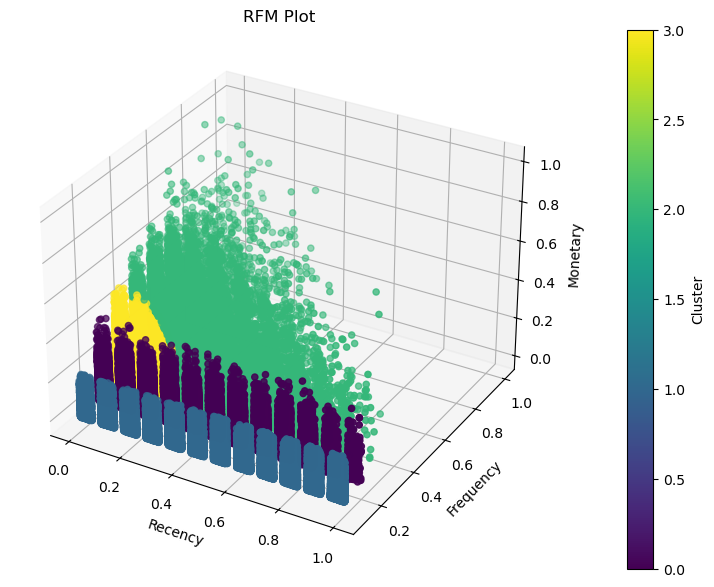

In [86]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(gaussian_rfm_df['Recency'], gaussian_rfm_df['Frequency'], gaussian_rfm_df['Monetary'], c=gaussian_rfm_df['Cluster'])

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Plot')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster')

plt.show()

It has quite clearly taking a very different approach to clustering, as the recency are pretty similair throughout, with there being a significant split between frequency and to a lesser degree monetary. Let's see how the last demographic analyses measure up to these clusters.

In [87]:
gaussian_cluster_df = df.merge(gaussian_rfm_df[['Cluster']], left_on='Customer_ID', right_index=True, how='left')
gaussian_cluster_df.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products,Cluster
0,8691788.0,37249.0,109110,16503,13801,118307,35,4,77985.0,2,...,1,10,23,2,1,2,3,5.0,86,0.0
1,2174773.0,69749.0,86175,35163,194622,245491,87,9,99071.0,3,...,2,14,28,2,2,1,2,4.0,164,3.0
2,6679610.0,30192.0,135685,44930,245087,123528,46,33,75929.0,0,...,0,11,3,0,1,1,2,2.0,268,0.0
5,6095326.0,41289.0,131823,20586,76129,159020,19,33,74430.0,0,...,2,1,28,3,0,3,1,4.0,164,2.0
6,5434096.0,97285.0,52576,4020,19165,179304,60,39,47545.0,1,...,2,14,29,1,2,0,2,1.0,228,0.0


In [89]:
gaussian_cluster_summary = gaussian_cluster_df.groupby('Cluster').agg({
    'Age': 'mean',
    'Gender': 'mean',
    'Income': 'mean',
    'Customer_Segment': 'mean'
}).rename(columns={
    'Age': 'Average Age',
    'Gender': 'Average Gender',
    'Income': 'Average Income',
    'Customer_Segment': 'Average Customer Segment'
})
print(gaussian_cluster_summary)
print(kmeans_cluster_summary)

         Average Age  Average Gender  Average Income  Average Customer Segment
Cluster                                                                       
0.0        35.425138        0.624782        1.188148                  1.183071
1.0        35.357544        0.620038        1.179502                  1.187325
2.0        35.566404        0.625388        1.183206                  1.180798
3.0        35.458947        0.616962        1.179885                  1.184815
         Average Age  Average Gender  Average Income  Average Customer Segment
Cluster                                                                       
0.0        35.481251        0.623812        1.184911                  1.189439
1.0        35.416617        0.623173        1.185674                  1.178581
2.0        35.602242        0.622077        1.180882                  1.185129
3.0        35.370101        0.622125        1.183234                  1.182301


I printed the two cluster summaries to show the differences. As you can tell, the significantly different clustering method still shows similair result in all person-based categories within the dataset. To draw a conclusion from this; while in some cases there may be very distinct characteristics of certain consumers, it is sadly a reality with this dataset that despite very visibly distinct cluster groups, with different methods, the demographics are very homogenous throughout, which shows a possible challenge in predicting consumer behaviour within diverse large retailers, like the one from the datset.